# First Project - EDA #

The data
- The datasets can be found in the respective folders in this repository.
- Each folder contains the dataset either as a .csv or .txt file. The description of
the column names can be found in the column_names.md files.
- The column names may NOT be clear at times:


Tasks for you
1. Create a new repo and a new virtual environment.
2. Through EDA/statistical analysis above please come up with AT LEAST 3
insights/recommendations for your stakeholder.
If you use linear regression in the exploration phase remember that R2
 close
to 1 is good.
3. Then, model this dataset with a multivariate linear regression to predict
b. For US Bank Wages: The salary (or log(salary)) as accurately as
possible. Note you can take either the perspective of an applicant or
company.
i. Split the dataset into a train and a test set. (use the sklearn split
method
https://scikit-learn.org/stable/modules/generated/sklearn.mod
el_selection.train_test_split.html )
ii. Use Root Mean Squared Error (RMSE) as your metric of success
and try to minimize this score on your test data.

The Deliverables
1. A well documented Jupyter Notebook (see here for an example) containing
the code you've written for this project and comments explaining it. This work
will need to be pushed to your GitHub repository in order to submit your
project (latest upload: 18.02.2020 12:00). Do not push all the analysis... just
the analysis that is relevant!
2. A Python script for training the model, printing out the model statistics and
saving the model.
3. An organized README.md file in the GitHub repository that describes the
contents of the repository. This file should be the source of information for
navigating through the repository.
4. A short Keynote/PowerPoint/Google Slides/Jupyter slides presentation
giving a high-level overview of your methodology and recommendations for
non-technical stakeholders. The duration of the presentation should be 10
minutes, then the discussion will continue for 5 minutes. Also put your slides
(delivered as a PDF export) on Github to get a well-rounded project

# Load Data

In [223]:
# for better EDA I allow Jupyter to print also intermediate results
# -----------------------------------------------------------------

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [224]:
# importing of python modules
# -------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy import stats
#import seaborn as sns
#import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split

%matplotlib inline

In [225]:
# loading project data
# --------------------

load = pd.read_csv('us_bank_wages/us_bank_wages.txt', delimiter='\t')
list(data.columns)

['SALARY', 'EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']

In [226]:
load.drop('Unnamed: 0', axis=1, inplace=True)
load.shape
load.head(5)
load.info()
load.describe()

(474, 6)

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
0,57000,15,27000,1,0,3
1,40200,16,18750,1,0,1
2,21450,12,12000,0,0,1
3,21900,8,13200,0,0,1
4,45000,15,21000,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SALARY    474 non-null    int64
 1   EDUC      474 non-null    int64
 2   SALBEGIN  474 non-null    int64
 3   GENDER    474 non-null    int64
 4   MINORITY  474 non-null    int64
 5   JOBCAT    474 non-null    int64
dtypes: int64(6)
memory usage: 22.3 KB


,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,34419.567511,13.491561,17016.086498,0.544304,0.219409,1.411392
std,17075.661465,2.884846,7870.638154,0.498559,0.414284,0.773201
min,15750.000000,8.000000,9000.000000,0.000000,0.000000,1.000000
25%,24000.000000,12.000000,12487.500000,0.000000,0.000000,1.000000
50%,28875.000000,12.000000,15000.000000,1.000000,0.000000,1.000000
75%,36937.500000,15.000000,17490.000000,1.000000,0.000000,1.000000
max,135000.000000,21.000000,79980.000000,1.000000,1.000000,3.000000


# EDA Start ...

# Column Names and descriptions for US Bank Wages data set
* **SALARY**:  current yearly salary in dollar [\$]
* **EDUC**: education (number of finished years)
* **SALBEGIN**: yearly salary at employee's first position at same bank in dollars [\$]
* **GENDER**: gender variable (0 for females, 1 for males)
* **MINORITY**: minority variable (0 for non-minorities, 1 for minorities)
* **JOBCAT**: - job category (1 for administrative jobs, 2 for custodial jobs, 3 for management jobs)

In [227]:
data = load.copy()

# checking for NaN data

data.isnull().sum()
data.isnull().values.any()

# de-skewing - explaination: the SALERY colmuns are right skewed and to compensate for that I use log() 
# 20210216 - i don't use log() for now do avoid unit conflicts
#data.eval('SALARY = log(SALARY)', inplace = True)
#data.eval('SALBEGIN = log(SALBEGIN)', inplace = True)

# delta is not giving any additional information - I will noit use it any more (2021-02-16)
#data.eval('DELTA = SALARY - SALBEGIN', inplace = True) # delta between start salery and salery
#data_ext

SALARY      0
EDUC        0
SALBEGIN    0
GENDER      0
MINORITY    0
JOBCAT      0
dtype: int64

False

In [228]:
# work copy of data

work = data.copy()

# craeting dummy vars - avoiding dummy-trap

'''dummy = pd.get_dummies(work['JOBCAT'], prefix='JOBCAT', drop_first=True)
work = pd.concat([work, dummy], axis=1)
if 'JOBCAT' in work.columns.to_list():
    work.drop('JOBCAT', axis=1, inplace=True)
if 'Unnamed: 0' in work.columns.to_list():
    work.drop('Unnamed: 0', axis=1, inplace=True)'''

'''dummy = pd.get_dummies(work['EDUC'], prefix='EDUC', drop_first=True)
work = pd.concat([work, dummy], axis=1)
if 'EDUC' in work.columns.to_list():
    work.drop('EDUC', axis=1, inplace=True)
if 'Unnamed: 0' in work.columns.to_list():
    work.drop('Unnamed: 0', axis=1, inplace=True)'''
   
#work = data.copy()
work.head()

"dummy = pd.get_dummies(work['JOBCAT'], prefix='JOBCAT', drop_first=True)\nwork = pd.concat([work, dummy], axis=1)\nif 'JOBCAT' in work.columns.to_list():\n    work.drop('JOBCAT', axis=1, inplace=True)\nif 'Unnamed: 0' in work.columns.to_list():\n    work.drop('Unnamed: 0', axis=1, inplace=True)"

"dummy = pd.get_dummies(work['EDUC'], prefix='EDUC', drop_first=True)\nwork = pd.concat([work, dummy], axis=1)\nif 'EDUC' in work.columns.to_list():\n    work.drop('EDUC', axis=1, inplace=True)\nif 'Unnamed: 0' in work.columns.to_list():\n    work.drop('Unnamed: 0', axis=1, inplace=True)"

,SALARY,EDUC,SALBEGIN,GENDER,MINORITY,JOBCAT
0,57000,15,27000,1,0,3
1,40200,16,18750,1,0,1
2,21450,12,12000,0,0,1
3,21900,8,13200,0,0,1
4,45000,15,21000,1,0,1


import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
data_ext.hist(ax = ax);

data_ext.groupby('JOBCAT').SALARY.hist(alpha=0.4)

In [229]:
#sns.pairplot(work)

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

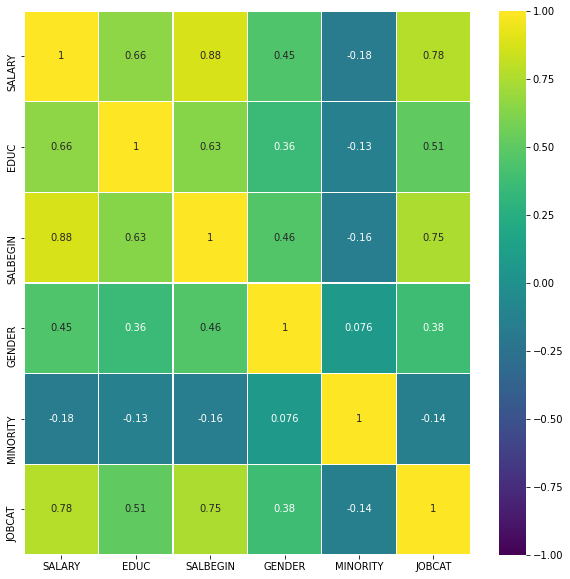

In [230]:
df_kor = work.corr()

plt.figure(figsize=(10,10))

sns.heatmap(df_kor, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

### The stackholder ###
Is a NGO that works on the integration of war-refugee girls into society.

### The task ###
The NGO has a suspicion that a curtain bank does not follow it own code of conduct.

### The question ###
- Would girls with a minority background have the same chances for a fair salery as non-minority women?
- Is there an difference in pay between male and female emplyees?
- What is the salery based on in the bank?

## Hypothesis ##

1. Salery depends on edcuation.
- H0: B_EDUC = 0
- H1: B_EDUC > 0
2. Salery depends on staring salery.
- H0: B_SALBEGIN = 0
- H1: B_SALBEGIN > 0
3. Salery depends not on being part of a minority.
- H0: B_MINORITY = 0
- H1: B_MINORITY > 0


We would expect mpg to decrease by 0.047 as horsepower goes up by 1, holding weight constant.

We would expect mpg to decrease by 0.006 as weight increases by 1, holding horsepower constant,


In [231]:
# spliting data into train ad test data

train, test = train_test_split(work, test_size=0.2, random_state=42, shuffle=True) # random_state = 42 means result can be re-generated 

train.shape
test.shape

(379, 6)

(95, 6)

In [232]:
# !!!!!!!!!!!!!! > > > > > > >  watch out ! exchange work with train  !!!!!!!!!!!!!!!!!!!

In [236]:
cols = train.columns.to_list()
cols.remove('SALARY')
cols
for col in cols:
    print(col)
    print('\t    rsquared:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared)
    print('\trsquared_adj:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().rsquared_adj)
    print('\t    f_pvalue:',smf.ols(formula=f'SALARY ~ '+col, data=train).fit().f_pvalue)

['EDUC', 'SALBEGIN', 'GENDER', 'MINORITY', 'JOBCAT']

EDUC
	    rsquared: 0.4492348651516894
	rsquared_adj: 0.44777394967463824
	    f_pvalue: 9.078725684143804e-51
SALBEGIN
	    rsquared: 0.7812131394829096
	rsquared_adj: 0.7806328029828643
	    f_pvalue: 1.8229693004773198e-126
GENDER
	    rsquared: 0.2109923305655248
	rsquared_adj: 0.20889947202591086
	    f_pvalue: 3.523498859191208e-21
MINORITY
	    rsquared: 0.0314140275695004
	rsquared_adj: 0.02884483400867688
	    f_pvalue: 0.000527120608253628
JOBCAT
	    rsquared: 0.6186414418746766
	rsquared_adj: 0.6176298807125404
	    f_pvalue: 6.286696641267465e-81


In [209]:
#' + '.join([x for x in work.columns.to_list()])

In [240]:
var = []
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])

var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])

var.append(['SALBEGIN','GENDER','C(MINORITY)'])
var.append(['SALBEGIN','GENDER','C(EDUC)'])
var.append(['SALBEGIN','C(JOBCAT)','C(EDUC)'])
var.append(['C(MINORITY)','C(JOBCAT)','C(EDUC)'])

var.append(['GENDER','C(JOBCAT)','C(EDUC)'])
var.append(['GENDER','C(MINORITY)','C(EDUC)'])
var.append(['GENDER','C(MINORITY)','C(JOBCAT)'])

var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)','C(JOBCAT)','C(EDUC)'])

var.append(['C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','C(JOBCAT)','C(EDUC)'])
var.append(['SALBEGIN','GENDER','C(MINORITY)'])

var.append(['C(MINORITY)','C(JOBCAT)','C(EDUC)'])
var.append(['GENDER','C(MINORITY)','C(JOBCAT)'])
var.append(['GENDER','C(MINORITY)','C(EDUC)'])
var.append(['GENDER','C(JOBCAT)','C(EDUC)'])

var.append(['SALBEGIN','C(MINORITY)'])
var.append(['SALBEGIN','C(JOBCAT)'])
var.append(['SALBEGIN','C(EDUC)'])
var.append(['SALBEGIN','GENDER',])
var.append(['GENDER','C(MINORITY)'])
var.append(['GENDER','C(JOBCAT)'])
var.append(['GENDER','C(EDUC)'])
var.append(['C(MINORITY)','C(JOBCAT)'])
var.append(['C(MINORITY)','C(EDUC)'])
var.append(['C(JOBCAT)','C(EDUC)'])

var.append(['SALBEGIN'])
var.append(['GENDER'])
var.append(['C(MINORITY)'])
var.append(['C(JOBCAT)'])
var.append(['C(EDUC)'])
               
var = list(set(var))

h = "SALARY ~ '
res = {}
for t in vars:
    f = h + ' + '.join(t)
    m = smf.ols(formula=f, data=train).fit()
    #np.sqrt(m.mse_resid)
    #m.f_pvalue
    #m.rsquared
    res[m.rsquared_adj] = f

max(res.keys)
res[max(res.keys)] # best fit

8350.315922328793

2.2670742423589404e-124

0.7839785249860765

0.782250353185965

In [239]:
smf.ols(formula=f, data=train).fit().summary()

TypeError: 'numpy.float64' object is not callable

In [172]:
temp = train.copy()
tg = train.groupby('GENDER').size().reset_index()
tg
'''cols = work.columns.to_list()
cols.remove('SALARY')
cols.remove('MINORITY')
smf.ols(formula=f'SALARY ~ '+' + '.join(cols), data=work).fit().summary()'''

AttributeError: 'Series' object has no attribute 'set_index'